# Simulation of Poisson Regression

## Import Libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Generate Fake Data

The genearted data is based on the poisson distrbution PMF

$$
P(d|t, \lambda) = \frac{\lambda(t; \mathbf{w})^d \cdot \exp(-\lambda(t; \mathbf{w}))}{d!}
$$

with mean count parameter defined by the piecewise function

$$
\lambda(t; \mathbf{w}) =
\begin{cases}
\exp(\alpha_{01} + \beta_{11}(t - 8)), & 8 < t \leq 9 \\
\exp(\alpha_{02} + \beta_{12}(t - 9)), & 9 < t \leq 12 \\
\exp(\alpha_{03} + \beta_{13}(t - 12)), & 12 < t \leq 15 \\
\exp(\alpha_{04} + \beta_{14}(t - 15)), & 15 < t \leq 17 \\
\exp(\alpha_{05} + \beta_{15}(t - 17)), & 17 < t < 18
\end{cases}
$$

In [2]:
def lambda_t(t, w):
    """
        Piecewise linear definition of λ(t; w) according to the description:
        - High in [8, 9]
        - Decreasing in [9, 12]
        - Constant in [12, 15]
        - Increasing in [15, 17]
        - Peak in [17, 18]

        Parameters:
        t: time (hours) 8 < t <= 17
        w: The parameter vector [alpha_01, beta_11, ..., alpha_05, beta_15]
    """
    if 8 < t <= 9:
        return np.exp(w[0] + w[1] * (t - 8)) 
    elif 9 < t <= 12:
        return np.exp(w[2] + w[3] * (t - 9))
    elif 12 < t <= 15:
        return np.exp(w[4] + w[5] * (t - 12))
    elif 15 < t <= 17:
        return np.exp(w[6] + w[7] * (t - 15))
    elif 17 < t < 18:
        return np.exp(w[8] + w[9] * (t - 17))
    else:
        raise ValueError("Time t is out of bounds [8, 18].")

In [3]:
def generate_data(num_points, w):
    t_data = []
    d_data = []
    intervals = [(8, 9), (9, 12), (12, 15), (15, 17), (17, 18)]
    points_per_interval = [int(num_points * (end - start) / 10) for start, end in intervals]
    
    for (start, end), num in zip(intervals, points_per_interval):
        t_values = np.random.uniform(start, end, num)  # Generate uniform t within the interval
        for t in t_values:
            lam = lambda_t(t, w)
            d = np.random.poisson(lam)  # Generate Poisson-distributed d
            t_data.append(t)
            d_data.append(d)
    
    return np.array(t_data), np.array(d_data)

In [4]:
# Example initial parameter vector for λ(t; w)
w = [4.5, -0.5, 4, -0.3, 3, 0, 3, 0.6, 4.2, 0.6]  

np.random.seed(42)
t_data, d_data = generate_data(num_points=500, w=w)

# Sort the data for visualization purposes
sorted_indices = np.argsort(t_data)
t_data = t_data[sorted_indices]
d_data = d_data[sorted_indices]

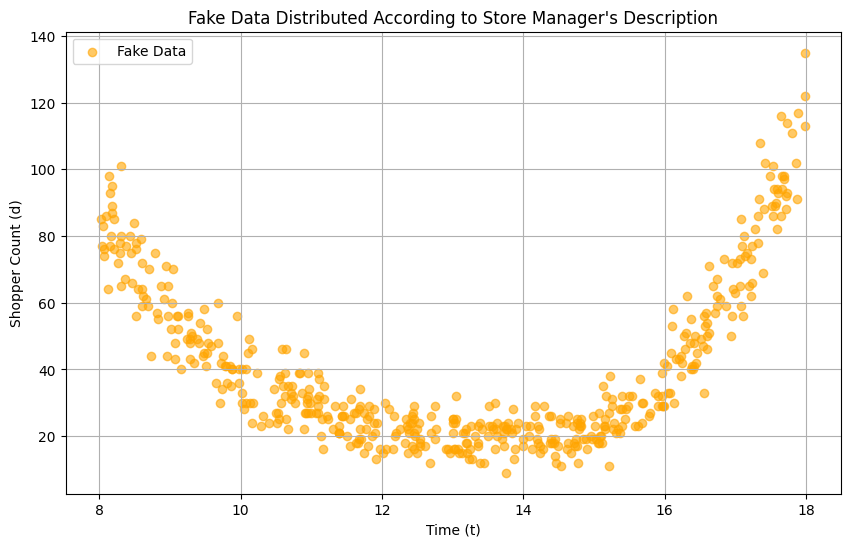

In [5]:
# Plot the fake data
plt.figure(figsize=(10, 6))
plt.scatter(t_data, d_data, alpha=0.6, color='orange', label="Fake Data")
plt.xlabel("Time (t)")
plt.ylabel("Shopper Count (d)")
plt.title("Fake Data Distributed According to Store Manager's Description")
plt.legend()
plt.grid(True)
plt.show()

## Compute Gradients and Negative Log-Likelihood

$$
\frac{\partial \ell(\lambda; D)}{\partial \mathbf{w}} = \sum_{i=1}^N \left[ \left(1 - \frac{d^{(i)}}{\lambda(t^{(i)}; \mathbf{w})}\right) \cdot \frac{\partial \lambda(t; \mathbf{w})}{\partial \mathbf{w}} \right]
$$

$$
\frac{\partial \lambda(t; \mathbf{w})}{\partial \beta_{1k}} = \lambda(t; \mathbf{w}) \cdot (t - t_k)
$$

$$
\frac{\partial \lambda(t; \mathbf{w})}{\partial \alpha_{0k}} = \lambda(t; \mathbf{w})
$$

In [6]:
def lambda_gradient(t, w):
    """
    Compute gradients of lambda with respect to w.
    
    Parameters:
        t: time (hours) 8 <= t <= 17
        w: The parameter vector [alpha_01, beta_11, ..., alpha_05, beta_15].
    
    Returns:
        array: Gradients of lambda with respect to w.
    """
    gradients = np.zeros_like(w)
    intervals = [(8, 9), (9, 12), (12, 15), (15, 17), (17, 18)]

    for k, (start, end) in enumerate(intervals):
        grad_alpha = 0
        grad_beta = 0
        if start < t <= end:
            lambda_val = lambda_t(t, w)
            grad_alpha = lambda_val
            grad_beta = (t - start) * lambda_val
        gradients[2 * k] = grad_alpha     # Gradient for alpha_k
        gradients[2 * k + 1] = grad_beta  # Gradient for beta_k
    return gradients

In [7]:
def nll_gradient(w, t_data, d_data):
    """
    Compute gradients of negative log-likelihood with respect to w.
    
    Parameters:
        w: The parameter vector [alpha_01, beta_11, ..., alpha_05, beta_15]
        t_data: time (hours) 8 <= t <= 17
        d_data: customer count d>0
    
    Returns:
        array: Gradient of negative log-likelihood (nll) with respect to w.
    """
    grad = np.zeros_like(w)
    n = len(t_data)
    
    for t, d in zip(t_data, d_data):
        lam = lambda_t(t, w)
        grad += (1 - (d / lam)) * lambda_gradient(t, w)
    return grad * (1 / n) # normalized

# Negative Log-Likelihood

$$
\ell(\lambda; D) = -L(\lambda; D) = \sum_{i=1}^N \lambda(t^{(i)}; \mathbf{w}) - d^{(i)} \cdot \log \lambda(t^{(i)}; \mathbf{w}) + \log d^{(i)}!
$$

The negative log-likelihood is minimised in the MLE as follows

$$
\hat{\mathbf{w}} := \arg\min_{\mathbf{w}} \ell(\lambda; D) = \arg\min_{\mathbf{w}} \sum_{i=1}^N \left( \lambda(t^{(i)}; \mathbf{w}) - d^{(i)} \cdot \log \lambda(t^{(i)}; \mathbf{w}) \right)
$$

In [8]:
def neg_log_likelihood(w, t_data, d_data):
    """
    Parameters:
        w: The parameter vector [alpha_01, beta_11, ..., alpha_05, beta_15]
        t_data: time (hours) 8 <= t <= 17
        d_data: customer count d>0
    
    Returns:
        array: negative log-likelihood (nll) with respect to w.
    """
    nll = 0
    n = len(t_data)
    
    for t, d in zip(t_data, d_data):
        lam = lambda_t(t, w)
        nll += -d * np.log(lam) + lam
    return nll * (1 / n) # normalized

## Gradient Descent

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \cdot \Delta \ell(\lambda; D)
$$

In [9]:
def gradient_descent(t_data, d_data, initial_w, learning_rate=0.01, max_iter=10000, tol=1e-4):
    """
    Parameters:
        t_data: time (hours) 8 <= t <= 17
        d_data: customer count d>0
        initial_w: The parameter vector [alpha_01, beta_11, ..., alpha_05, beta_15]
        learning_rate: size of the steps taken during each update
        max_iter: maximum number of iterations/epochs
        tol: tolerance below which convergence is reached
    
    Returns:
        array: negative log-likelihood (nll) with respect to w.
    """
    w = np.array(initial_w)
    nlls = []
    convergence = 0
    for i in range(max_iter):
        nll = neg_log_likelihood(w, t_data, d_data)
        grad = nll_gradient(w, t_data, d_data)
        # Update paramter vector
        w = w - learning_rate * grad
        nlls.append(nll)
        if np.linalg.norm(grad) < tol:
            convergence = i+1
            print(f"Converged after {convergence} iterations.")
            break
    else:
        print("Gradient descent did not converge within the maximum number of iterations.")
    return w, nlls, convergence

## Plot Result

Converged after 2022 iterations.


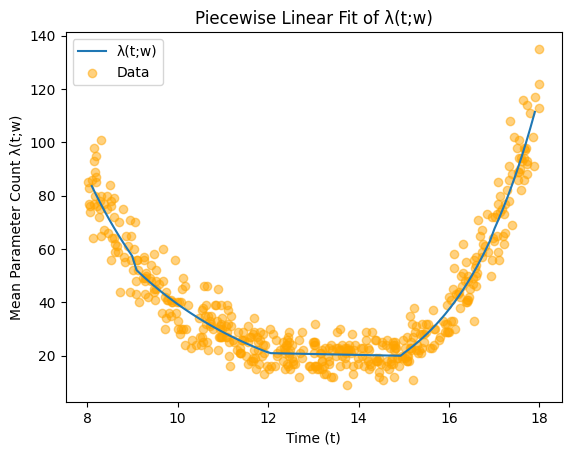

In [10]:
# Initial guess for parameters
np.random.seed(42)
initial_w = np.random.uniform(0.1, 1, 10)

# Perform gradient descent
n_iter = 10000
optimized_w, nlls, convergence = gradient_descent(t_data, d_data, initial_w, learning_rate=0.01, max_iter=n_iter)

# Evaluate the optimized λ(t;w)
t_test = np.linspace(8.1, 17.9, 100)
lambda_test = [lambda_t(t, optimized_w) for t in t_test]

# Plot Mean Count Parameter against Time
plt.plot(t_test, lambda_test, label="λ(t;w)")
plt.scatter(t_data, d_data, alpha=0.5, color='orange', label="Data")
plt.xlabel("Time (t)")
plt.ylabel("Mean Parameter Count λ(t;w)")
plt.title("Piecewise Linear Fit of λ(t;w)")
plt.legend()
plt.show()

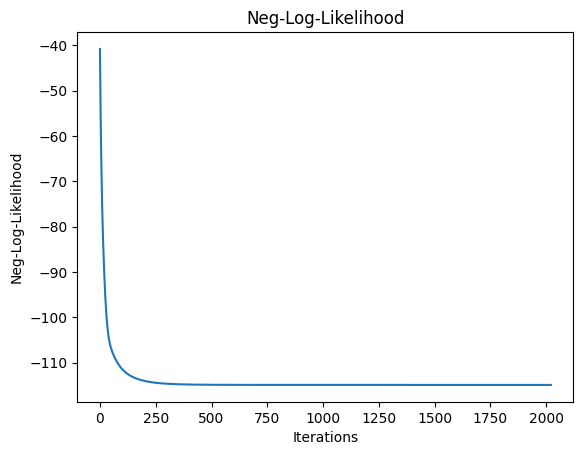

In [11]:
# Plot minimization of Neg-Log-Likelihood
plt.plot(np.arange(0, convergence), nlls[:convergence])
plt.xlabel("Iterations")
plt.ylabel("Neg-Log-Likelihood")
plt.title("Neg-Log-Likelihood")
plt.show()